In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('/usr0/home/naveenr/projects/patient_provider')

In [5]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import argparse
import secrets
import json
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 

In [6]:
from patient.utils import get_results_matching_parameters,aggregate_data, aggregate_normalize_data

In [7]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [8]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [13]:
colors_by_method = {}
baseline_methods = ['random','greedy_basic','greedy','']
lp_methods = ['lp','lp_multiple_match','lp_fairness','lp_more_patients','lp_threshold']
patient_provider_methods = ['group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
linear_regularization_methods = ['provider_focused_linear_regularization_{}'.format(i) for i in [0.25,0.5,1,2,4]]
log_regularization_methods = ['provider_focused_log_regularization_{}'.format(i) for i in [0.25,0.5,1,2,4]]

greys = plt.cm.Greys(np.linspace(0, 1, len(baseline_methods)+1))
vidris = plt.cm.coolwarm(np.linspace(0, 1, len(lp_methods)))
wistia = plt.cm.Wistia(np.linspace(0, 1, len(patient_provider_methods)))
vidris_2 = plt.cm.coolwarm(np.linspace(0, 1, len(linear_regularization_methods)))
wistia_2 = plt.cm.Wistia(np.linspace(0, 1, len(log_regularization_methods)))


for i,m in enumerate(baseline_methods):
    colors_by_method[m] = greys[i+1]
for i,m in enumerate(lp_methods):
    colors_by_method[m] = vidris[i]
for i,m in enumerate(patient_provider_methods):
    colors_by_method[m] = wistia[i]
for i,m in enumerate(linear_regularization_methods):
    colors_by_method[m] = vidris_2[i]
for i,m in enumerate(log_regularization_methods):
    colors_by_method[m] = wistia_2[i]


colors_by_method['optimal'] = np.array([0.9,0.05,0.05,1.0])
colors_by_method['optimal_order'] = np.array([0.9,0.05,0.05,1.0])

In [14]:
shapes_by_method = {}
all_shapes = ['P','o','v','D','s','x','^','<','>']
for i,m in enumerate(baseline_methods+lp_methods+patient_provider_methods):
    shapes_by_method[m] = all_shapes[i%len(all_shapes)]

# EC Plots

## Performance Comparison

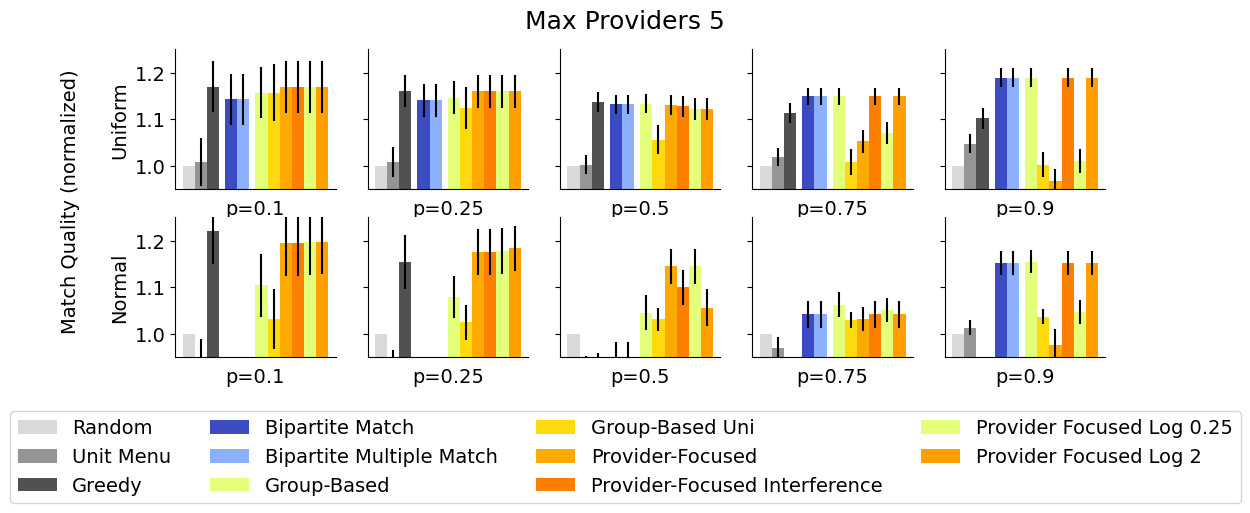

In [19]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference','provider_focused_log_regularization_0.25','provider_focused_log_regularization_2']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference','Provider Focused Log 0.25','Provider Focused Log 2']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 5}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']
        ]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.suptitle("Max Providers 5",fontsize=18)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/max_menu_5.pdf",dpi=300, bbox_inches='tight')


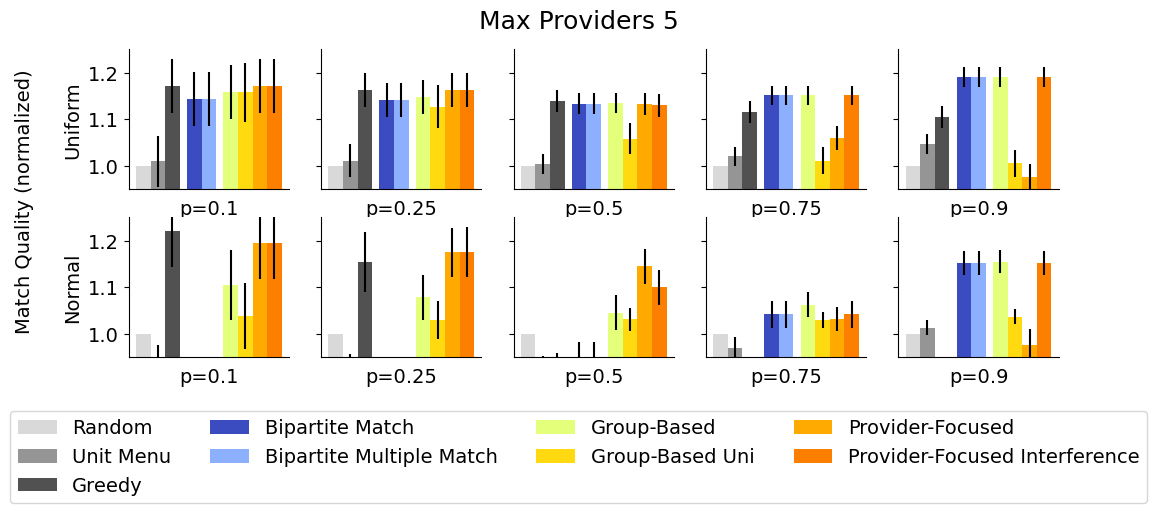

In [11]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 5}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.suptitle("Max Providers 5",fontsize=18)
fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/max_menu_5.pdf",dpi=300, bbox_inches='tight')


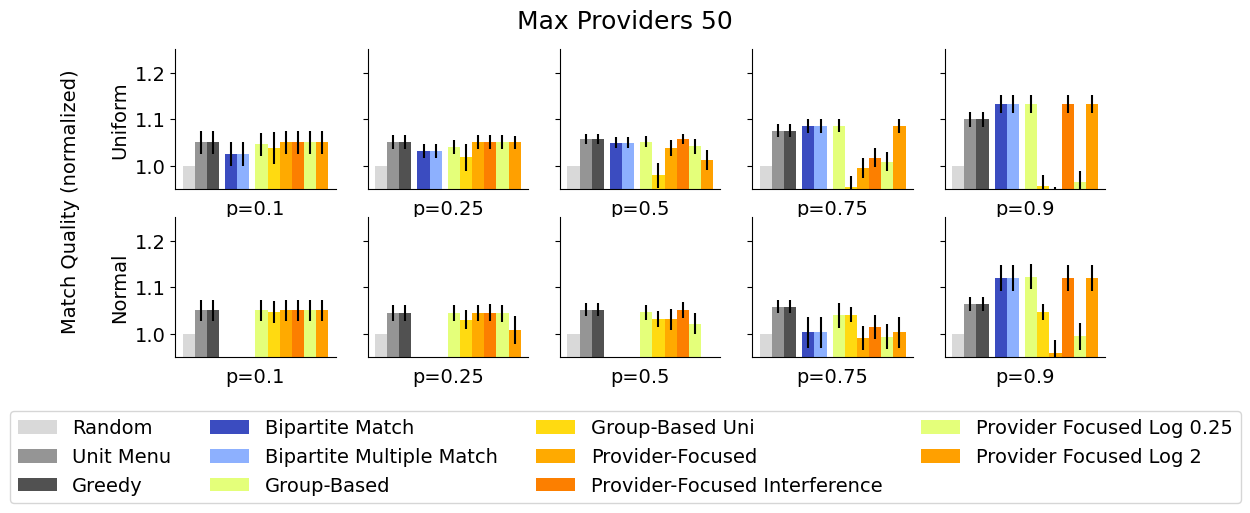

In [18]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference','provider_focused_log_regularization_0.25','provider_focused_log_regularization_2']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference','Provider Focused Log 0.25','Provider Focused Log 2']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']
        ]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.suptitle("Max Providers 50",fontsize=18)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/max_menu_50.pdf",dpi=300, bbox_inches='tight')


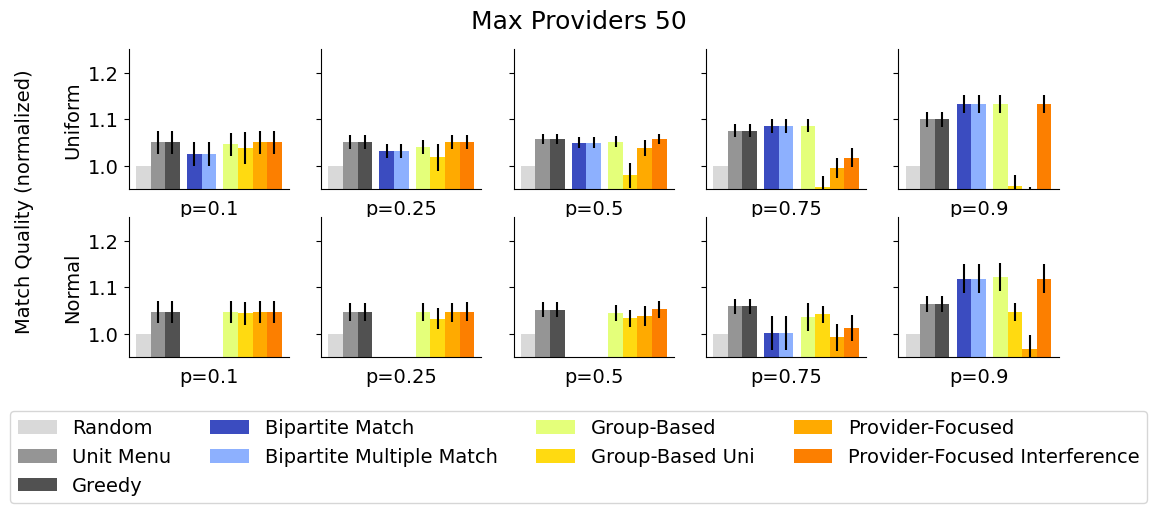

In [12]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']
        ]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.suptitle("Max Providers 50",fontsize=18)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/max_menu_50.pdf",dpi=300, bbox_inches='tight')


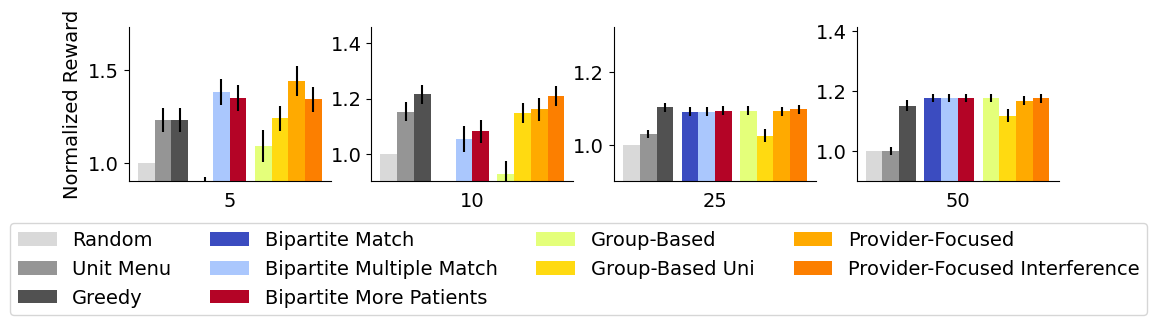

<Figure size 700x400 with 0 Axes>

In [25]:
fig, axs = plt.subplots(1,4, figsize=(12, 2))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_more_patients','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite More Patients",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_patients': 25}
dataset = "providers_patients"
num_providers = [5,10,25,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_providers'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.9,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/vary_providers.pdf",dpi=300, bbox_inches='tight')


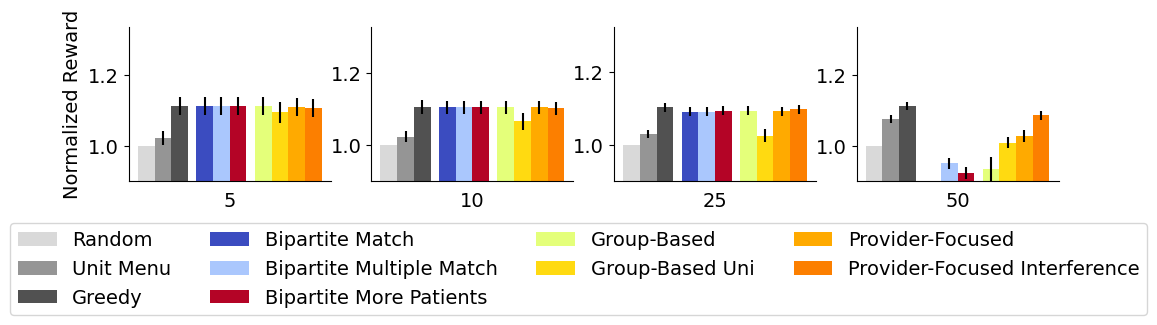

<Figure size 700x400 with 0 Axes>

In [26]:
fig, axs = plt.subplots(1,4, figsize=(12, 2))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_more_patients','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite More Patients",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25}
dataset = "providers_patients"
num_providers = [5,10,25,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_patients'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.9,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/vary_patients.pdf",dpi=300, bbox_inches='tight')


### Small Patients, Providers

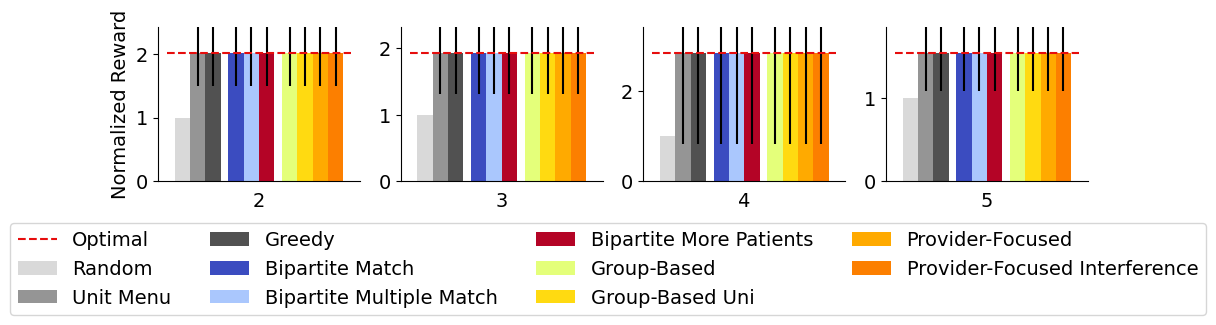

<Figure size 700x400 with 0 Axes>

In [27]:
fig, axs = plt.subplots(1,4, figsize=(12, 2))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_more_patients','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference','optimal']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite More Patients",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference','Optimal']
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_patients': 1}
dataset = "small"
num_providers = [2,3,4,5]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_providers'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            max_val = results['{}_utilities'.format(m)][0]
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_patients.pdf",dpi=300, bbox_inches='tight')


30
30
30
30


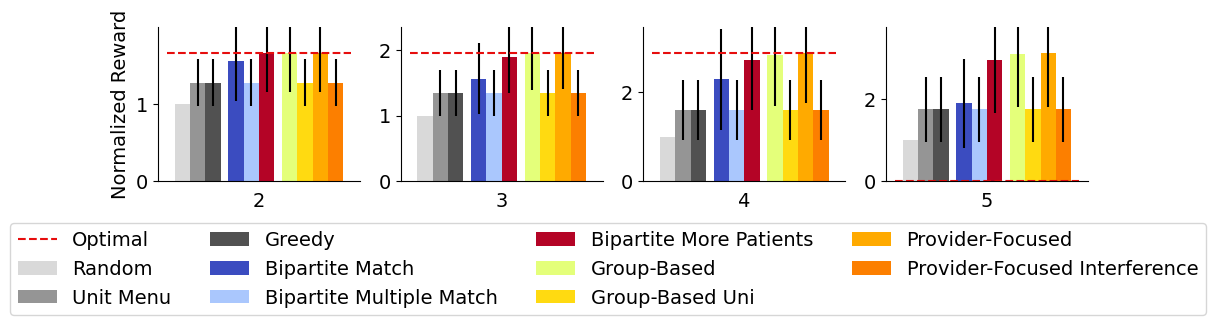

<Figure size 700x400 with 0 Axes>

In [28]:
fig, axs = plt.subplots(1,4, figsize=(12, 2))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_more_patients','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference','optimal']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite More Patients",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference','Optimal']
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 1}
dataset = "small"
num_patients = [2,3,4,5]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_patients)):
    baseline_params['num_patients'] = num_patients[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    print(num_data)
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0,max_val*1.2])
        axs[i].set_xlabel(num_patients[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/small_providers.pdf",dpi=300, bbox_inches='tight')


## Misspecification

{'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5, 'max_menu_size': 25, 'true_top_choice_prob': 0.1, 'top_choice_prob': -0.4}
0 0 0
{'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5, 'max_menu_size': 25, 'true_top_choice_prob': 0.1, 'top_choice_prob': -0.15}
0 1 0
{'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5, 'max_menu_size': 25, 'true_top_choice_prob': 0.1, 'top_choice_prob': 0.0}
0 2 0
{'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5, 'max_menu_size': 25, 'true_top_choice_prob': 0.1, 'top_choice_prob': 0.2}
0 3 6
0 3 6
{'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5, 'max_menu_size': 25, 'true_top_choice_prob': 0.1, 'top_choice_prob': 0.35}
0 4 6
0 4 6
{'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5, 'max_menu_size': 25, 'true

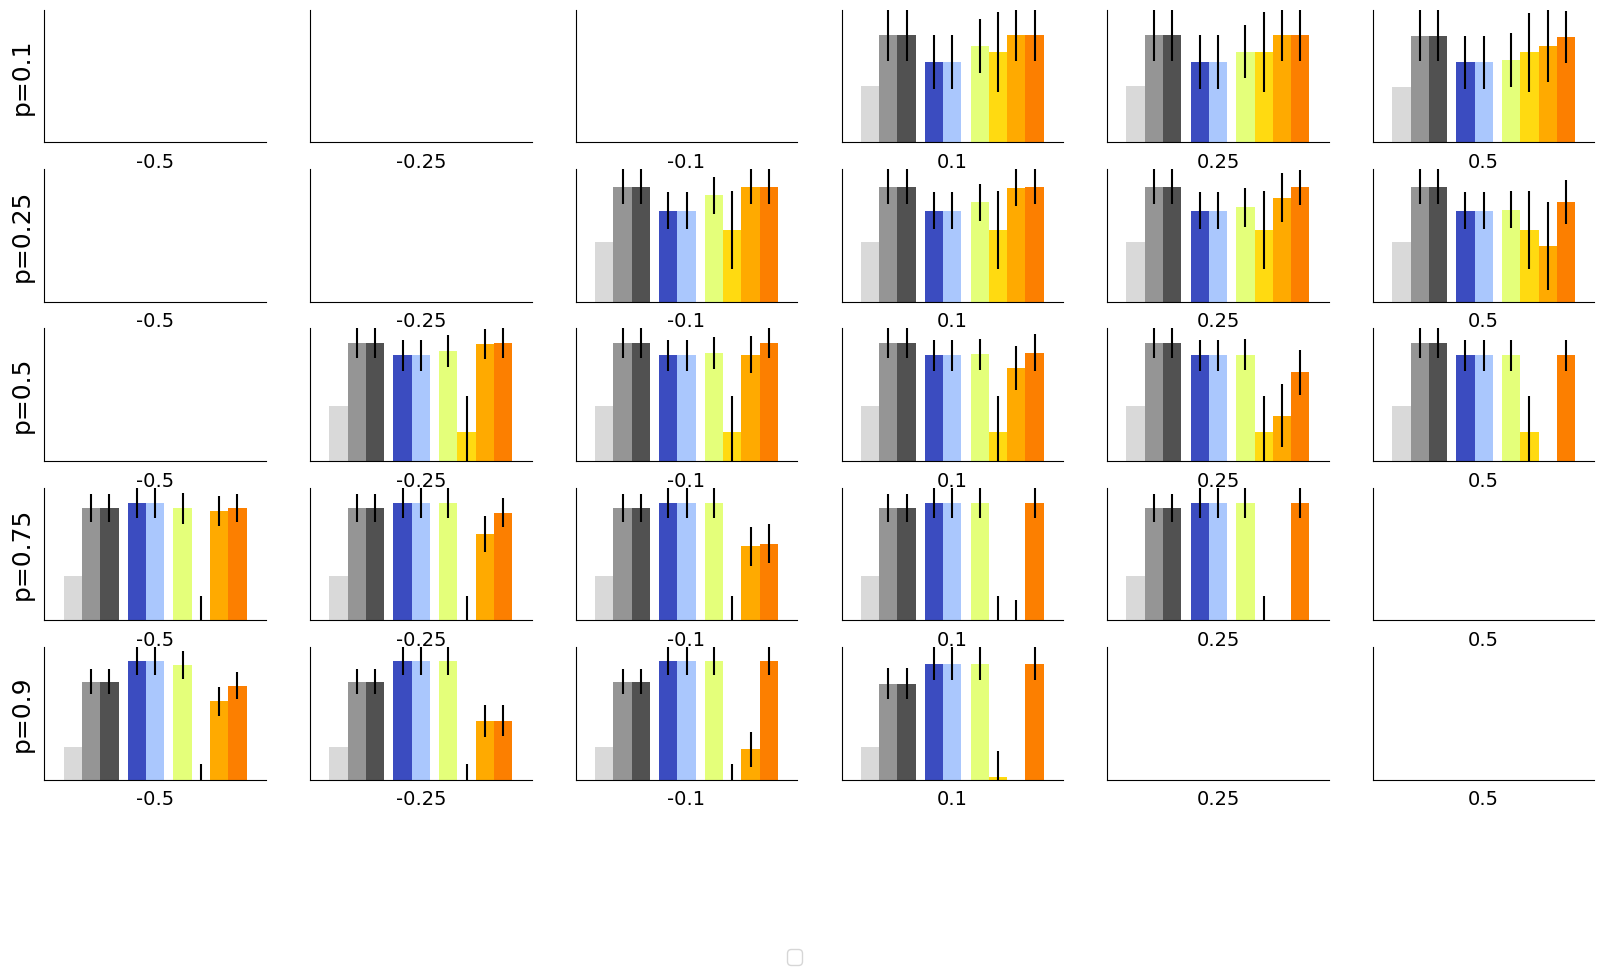

<Figure size 700x400 with 0 Axes>

In [19]:
fig, axs = plt.subplots(5,6, figsize=(20, 10))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference','optimal']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference','Optimal']
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'exit_option': 0.5, 'max_menu_size': 25}
dataset = "misspecification"
choice_prob = [0.1,0.25,0.5,0.75,0.9]
shift_list = [-0.5,-0.25,-0.1,0.1,0.25,0.5]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(choice_prob)):
    for j in range(len(shift_list)):
        baseline_params['true_top_choice_prob'] = choice_prob[i]
        baseline_params['top_choice_prob'] = choice_prob[i]+shift_list[j]
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_xlabel(shift_list[j],fontsize=14)
        if j == 0:
            axs[i][j].set_ylabel("p="+str(choice_prob[i]))        

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)
        print(baseline_params)
        print(i,j,len(results))
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        if num_data == 0:
            continue 
        
        results = aggregate_normalize_data(results,baseline='random')

        print(i,j,num_data)

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)
        

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0]+results['{}_utilities'.format(m)][1]/num_data**.5)

            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0.95,max_val])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/misspecification_p.pdf",dpi=300, bbox_inches='tight')


0 0 15
0 1 15
0 2 15
0 3 30
1 0 15
1 1 15
1 2 15
1 3 30
2 0 15
2 1 15
2 2 15
2 3 30
3 0 15
3 1 15
3 2 15
3 3 30
4 0 15
4 1 15
4 2 15
4 3 30


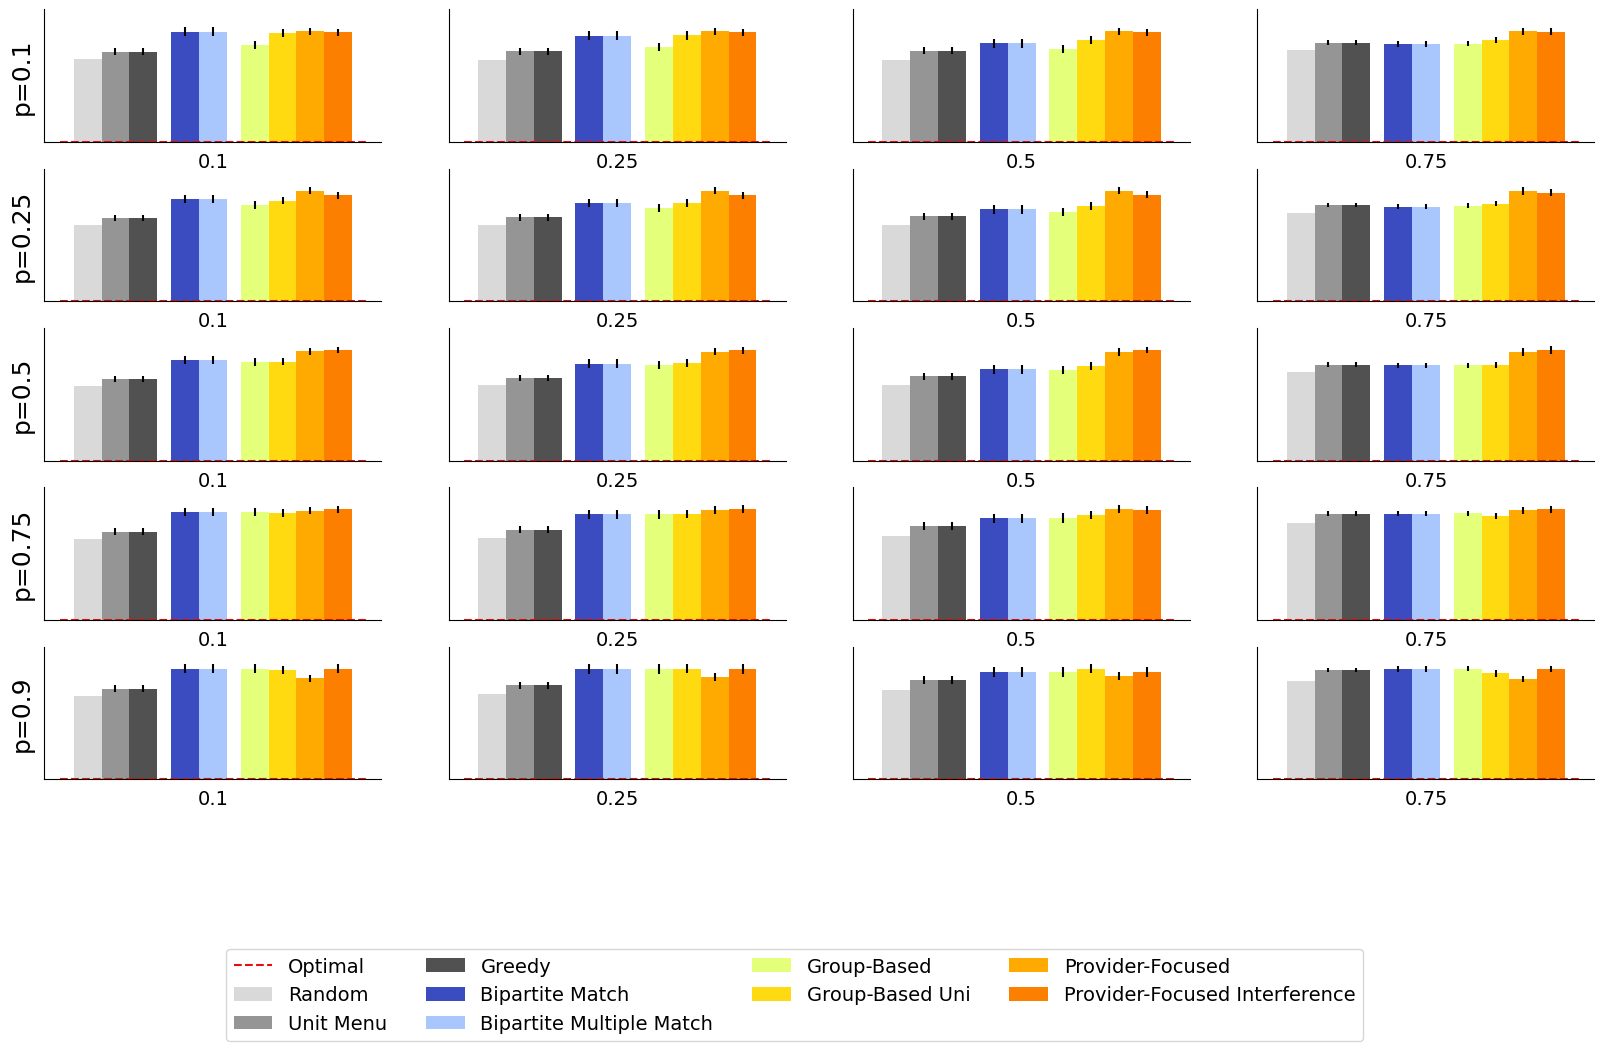

<Figure size 700x400 with 0 Axes>

In [31]:
fig, axs = plt.subplots(5,4, figsize=(20, 10))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'max_menu_size': 25}
dataset = "misspecification"
choice_prob = [0.1,0.25,0.5,0.75,0.9]
exit_options = [0.1,0.25,0.5,0.75]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(choice_prob)):
    for j in range(len(exit_options)):
        baseline_params['true_top_choice_prob'] = choice_prob[i]
        baseline_params['top_choice_prob'] = choice_prob[i]
        baseline_params['exit_option'] = exit_options[j]
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_xlabel(exit_options[j],fontsize=14)
        if j == 0:
            axs[i][j].set_ylabel("p="+str(choice_prob[i]))        

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)

        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        if num_data == 0:
            continue 
        
        results = aggregate_normalize_data(results,baseline='random')

        print(i,j,num_data)

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)
        

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0,max_val*1.2])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)
fig.savefig("../../results/figures/mnl.pdf",dpi=300, bbox_inches='tight')


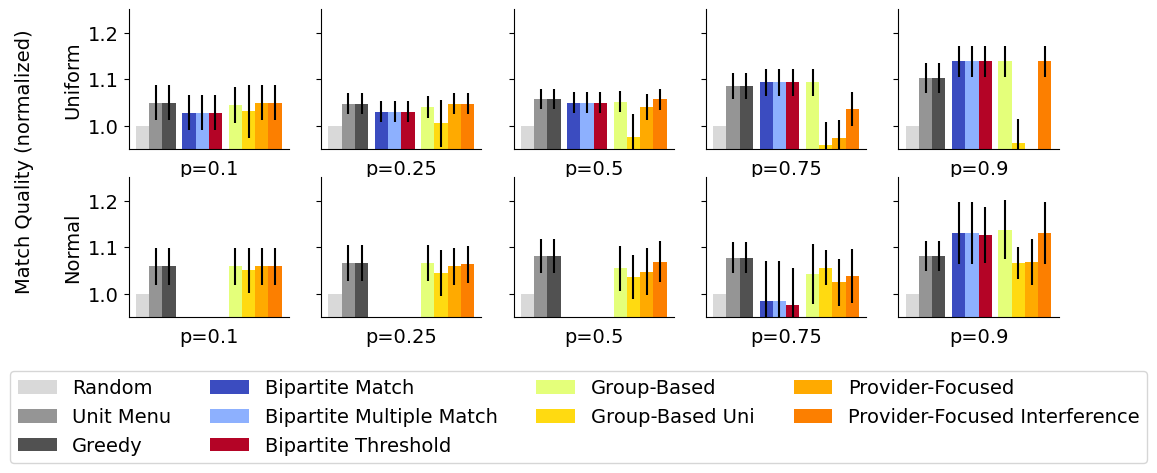

In [34]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_threshold','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite Threshold",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'threshold','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25}
dataset = "misspecification"

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/threshold_choice.pdf",dpi=300, bbox_inches='tight')


## Semi-Synthetic

/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr0/home/naveenr/miniconda3/envs/patient/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


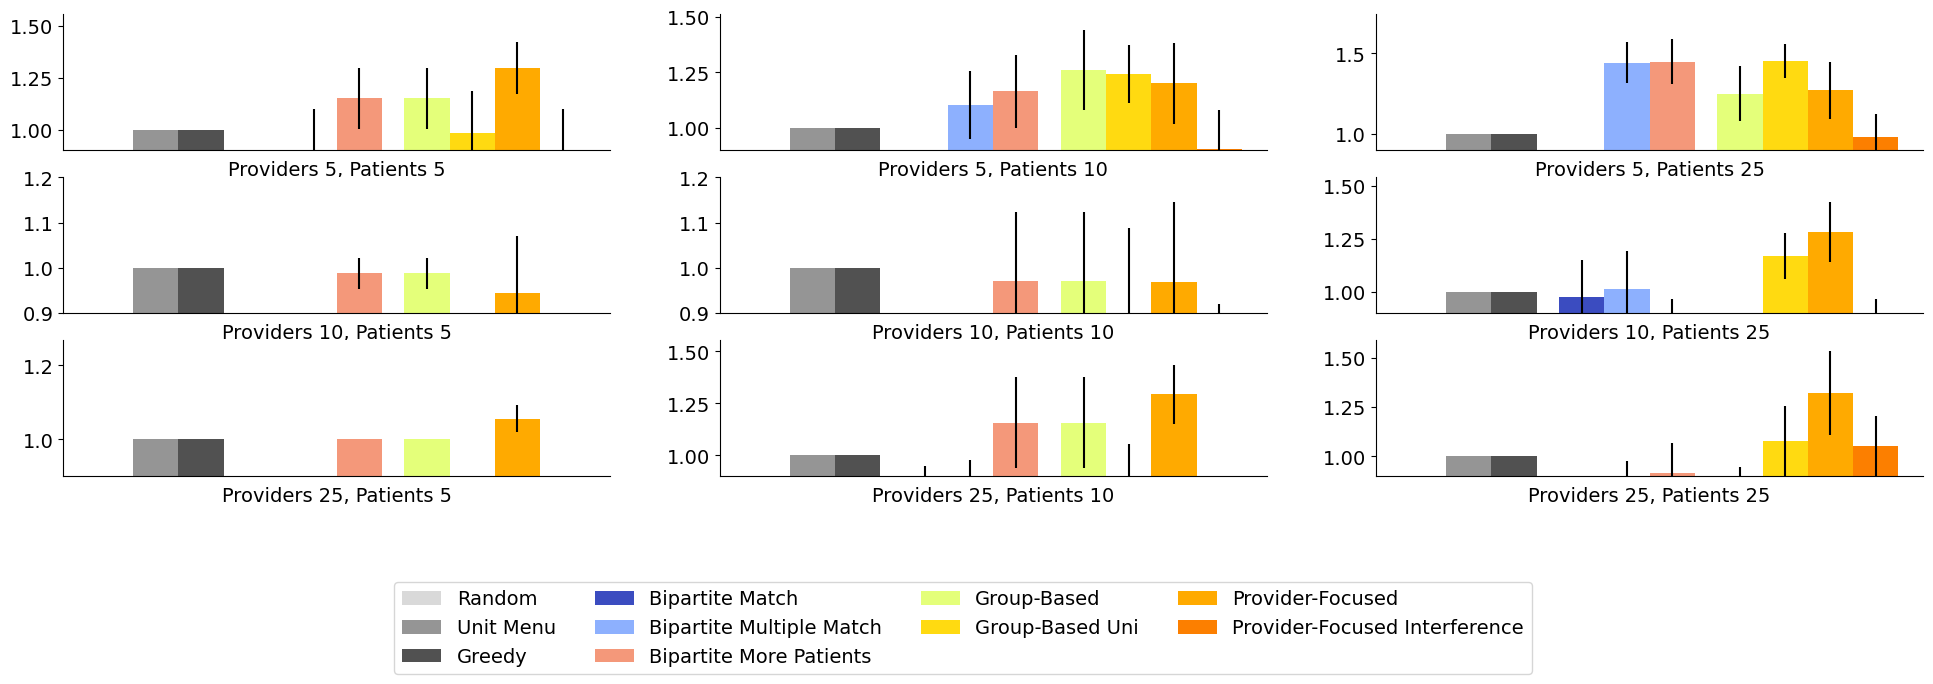

In [53]:
fig, axs = plt.subplots(3,3, figsize=(24, 6))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_more_patients','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite More Patients",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1

baseline_params = {}# {'utility_function': 'mnl_max', 'num_patients': 25}
dataset = "semi_synthetic"
num_providers = [5,10,25]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    for j in range(len(num_providers)):
        baseline_params['num_providers'] = num_providers[i]
        baseline_params['num_patients'] = num_providers[j]

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['greedy_utilities'])
        results = aggregate_normalize_data(results,baseline='greedy_basic')

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].set_xticks([])
            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0.9,max_val*1.2])
            axs[i][j].set_xlabel("Providers {}, Patients {}".format(num_providers[i],num_providers[j]),fontsize=14)
        

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/semi_synthetic.pdf",dpi=300, bbox_inches='tight')


## Ordering

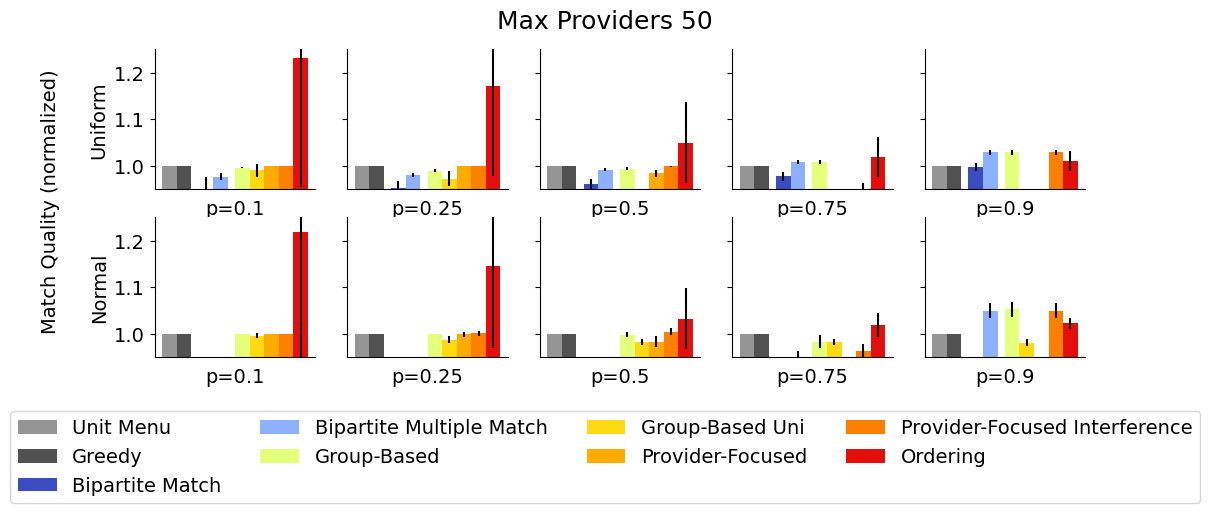

In [54]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference','optimal_order']
nice_names = ["Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference','Ordering']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50, 'order': 'custom'}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "ordering"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="greedy_basic")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.suptitle("Max Providers 50",fontsize=18)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/ordering_comparison.pdf",dpi=300, bbox_inches='tight')


## Iterative

0 0 21
0 1 21
0 2 21
0 3 20
1 0 21
1 1 21
1 2 21
1 3 21
2 0 21
2 1 21
2 2 21
2 3 21


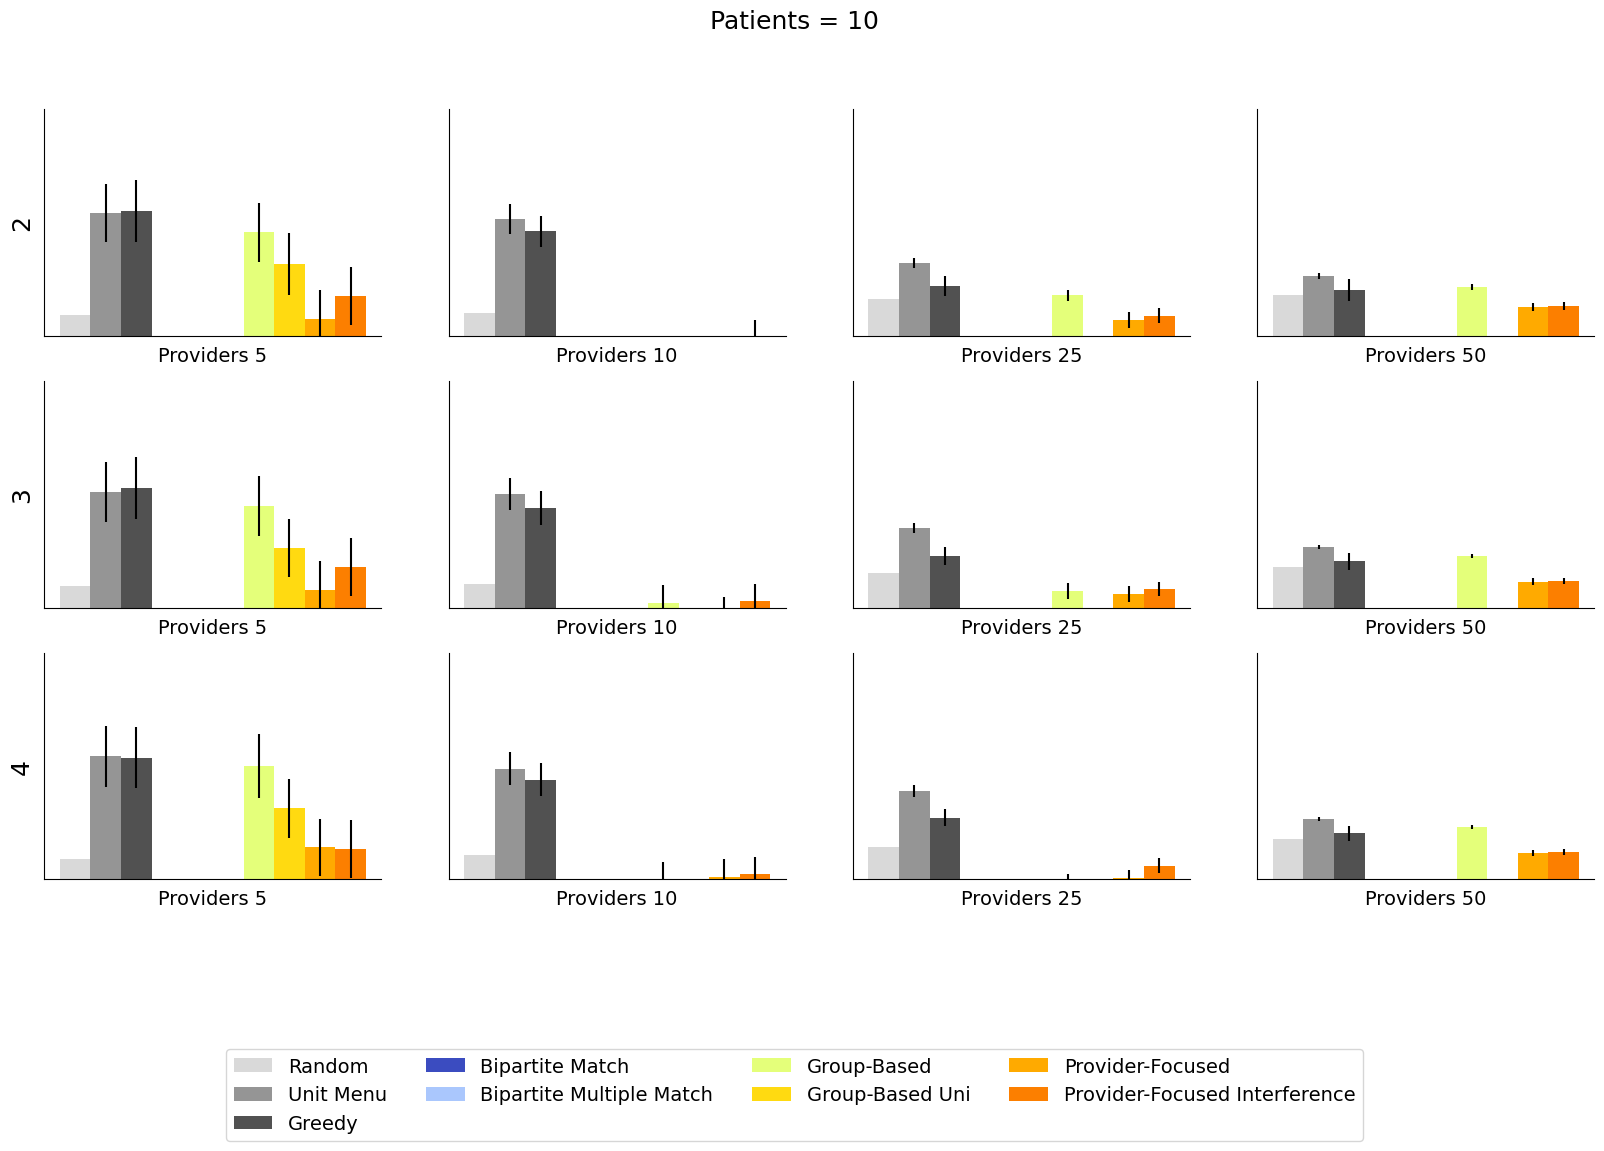

<Figure size 700x400 with 0 Axes>

In [37]:
fig, axs = plt.subplots(3,4, figsize=(20, 10))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'num_patients': 10}
dataset = "iterative"
n_providers = [5,10,25,50]
iterations = [2,3,4]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(iterations)):
    for j in range(len(n_providers)):
        baseline_params['num_repetitions'] = iterations[i]
        baseline_params['num_providers'] = n_providers[j]
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_xlabel("Providers "+str(n_providers[j]),fontsize=14)
        if j == 0:
            axs[i][j].set_ylabel(str(iterations[i]))        

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        if num_data == 0:
            continue 
        
        results = aggregate_normalize_data(results,baseline='random')

        print(i,j,num_data)

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)
        

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0.95,max_val*1.2])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)
fig.suptitle("Patients = 10",fontsize=18)
fig.savefig("../../results/figures/iterative_10_patients.pdf",dpi=300, bbox_inches='tight')


0 0 21
0 1 21
0 2 21
1 0 20
1 1 21
1 2 21
2 0 18
2 1 18
2 2 21


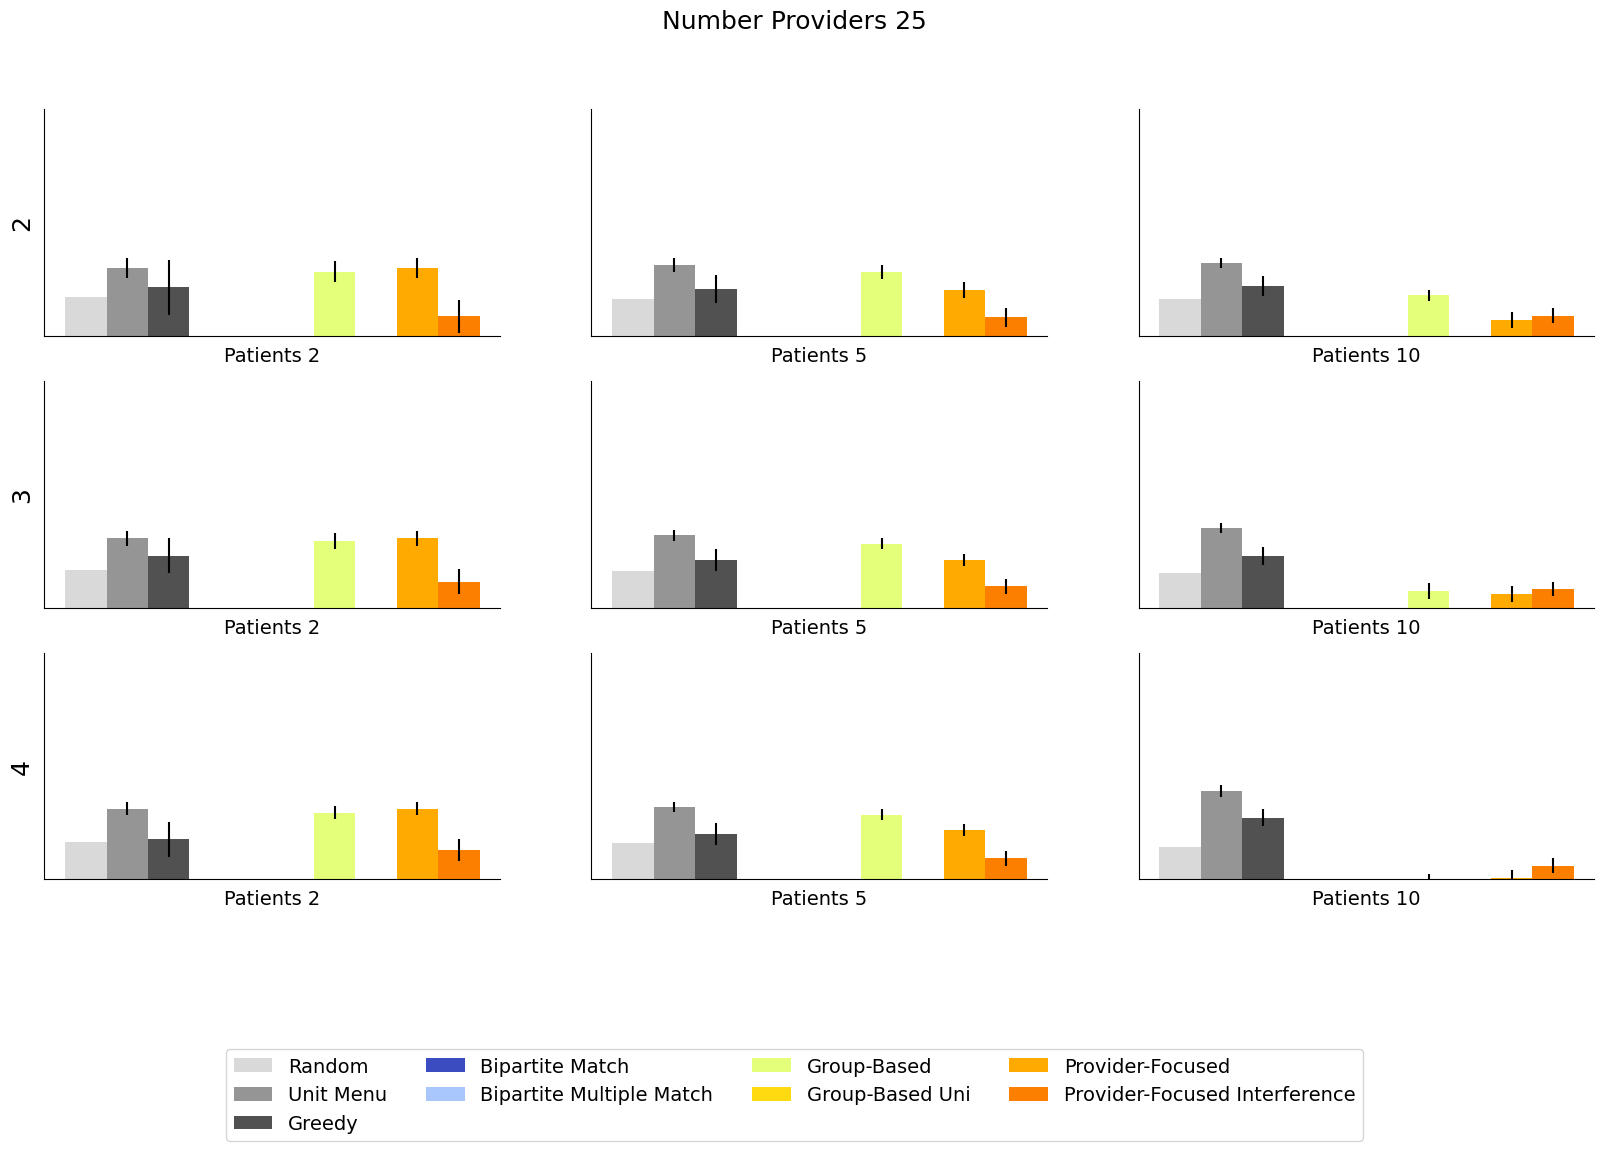

<Figure size 700x400 with 0 Axes>

In [40]:
fig, axs = plt.subplots(3,3, figsize=(20, 10))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'num_providers': 25}
dataset = "iterative"
n_providers = [2,5,10]
iterations = [2,3,4]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(iterations)):
    for j in range(len(n_providers)):
        baseline_params['num_repetitions'] = iterations[i]
        baseline_params['num_patients'] = n_providers[j]
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        axs[i][j].set_xlabel("Patients "+str(n_providers[j]),fontsize=14)
        if j == 0:
            axs[i][j].set_ylabel(str(iterations[i]))        

        max_val = 0
        results = get_results_matching_parameters(dataset,"",baseline_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)*len(results[0]['random_utilities'])
        if num_data == 0:
            continue 
        
        results = aggregate_normalize_data(results,baseline='random')

        print(i,j,num_data)

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []

            if '{}_utilities'.format(m) not in results:
                results['{}_utilities'.format(m)] = [0,0]
            score_by_n.append(results['{}_utilities'.format(m)][0])
            std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)
        

            if m == 'optimal':
                axs[i][j].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
            else:
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

            axs[i][j].tick_params(axis='both', which='major', labelsize=14)
            axs[i][j].set_ylim([0.95,max_val*1.2])

handles, labels = axs[0][0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)
fig.suptitle("Number Providers 25",fontsize=18)
fig.savefig("../../results/figures/iterative_25_providers.pdf",dpi=300, bbox_inches='tight')


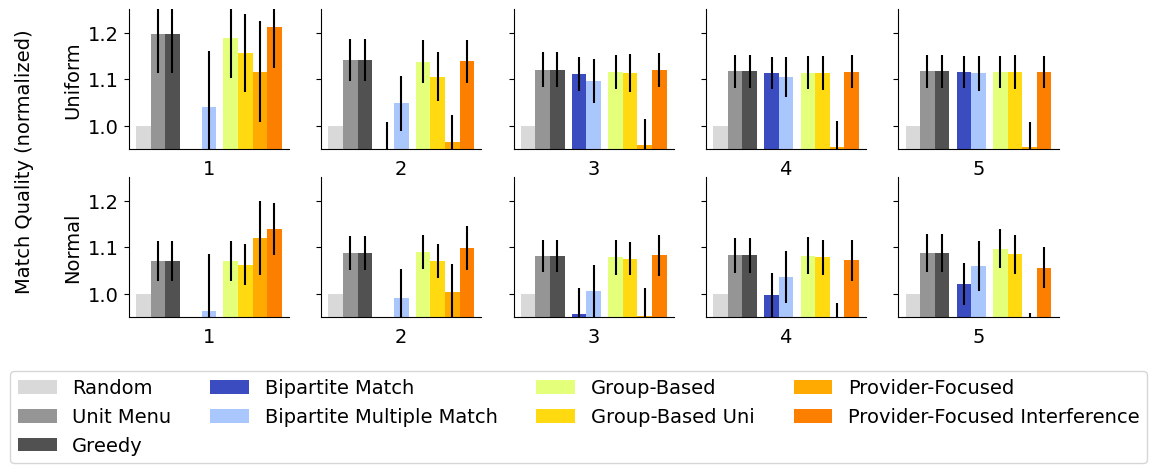

In [30]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
provider_capacity = [1,2,3,4,5]
utility_functions = ['uniform','normal']
dataset = "iterative"

baseline_params = {'choice_model': 'uniform_choice','num_patients': 25, 'num_providers': 10, 'true_top_choice_prob': 0.5}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(provider_capacity):
        max_val = 0
        min_val = 1
        baseline_params['provider_capacity'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_utilities'.format(m)][0])
                std_by_n.append(results['{}_utilities'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
                max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([1,1.1,1.2])

        if j == 0:
            axs[i,j].tick_params(axis='both', which='major', labelsize=14)
        else:
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

        axs[i,j].set_ylim([0.95,1.25])
        axs[i,j].set_xlabel("{}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)

fig.supylabel("Match Quality (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/provider_capacity.pdf",dpi=300, bbox_inches='tight')


## Workloads

[0.09651977300546329]
[0.003805436807750162]
[0.003805436807750162]
[0.0]
[0.003805436807750162]
[0.011189569700020977]
[0.003805436807750162]
[0.003805436807750162]
[0.003805436807750162]
[0.003805436807750162]
[0.23259687726559128]
[0.1904847934366502]
[0.1904847934366502]
[0.03215262023046967]
[0.16038060162876971]
[0.29975985027918645]
[0.14391686534068004]
[0.15682154228388137]
[0.1904847934366502]
[0.1904847934366502]
[0.3094619639877957]
[0.4538928798113906]
[0.4538928798113906]
[0.043362255763430765]
[0.3202623051318939]
[0.45818085039519174]
[0.33911256693851966]
[0.37899977165191623]
[0.4225042551978685]
[0.44028528957222746]
[0.38605182559899326]
[0.5097958969595695]
[0.5097958969595695]
[0.05141355276844539]
[0.39580562566669786]
[0.5089172614200189]
[0.3997510270574593]
[0.4275434345115953]
[0.467166706533524]
[0.44524957344437316]
[0.433393066843082]
[0.5256755608170375]
[0.5256755608170375]
[0.05188620331823041]
[0.4465694012276321]
[0.5140016498228375]
[0.44656940122763

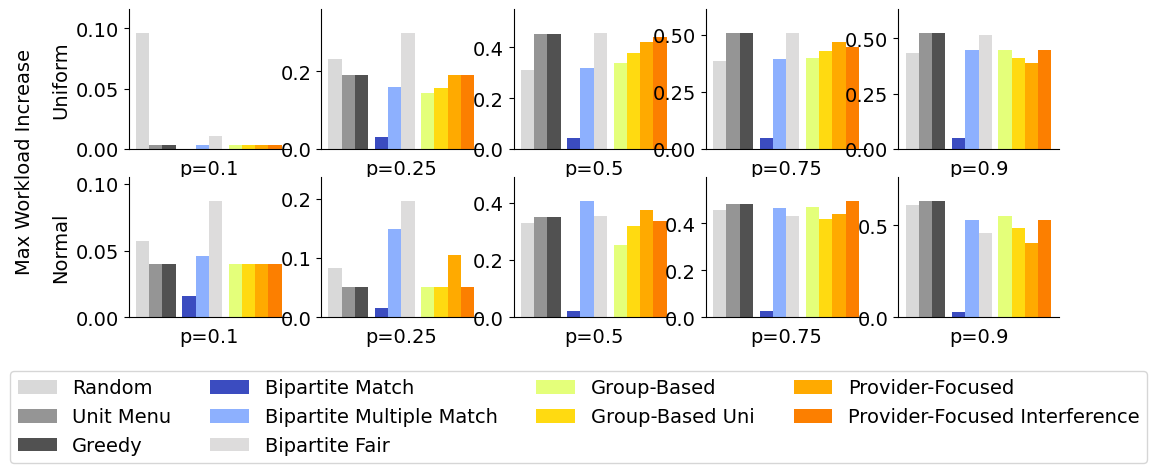

In [52]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_fairness','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite Fair",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline='random')

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_workload_diff'.format(m)][0])
                std_by_n.append(results['{}_workload_diff'.format(m)][1]/(num_data**.5))
                                
                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m])
                max_val = max(max_val,results['{}_workload_diff'.format(m)][0])
            print(score_by_n)

        axs[i,j].set_xticks([])

        axs[i,j].tick_params(axis='both', which='major', labelsize=14)

        axs[i,j].set_ylim([0,max_val*1.2])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.supylabel("Max Workload Increase",fontsize=14,x=0.03)
fig.savefig("../../results/figures/workload.pdf",dpi=300, bbox_inches='tight')


### Fairness

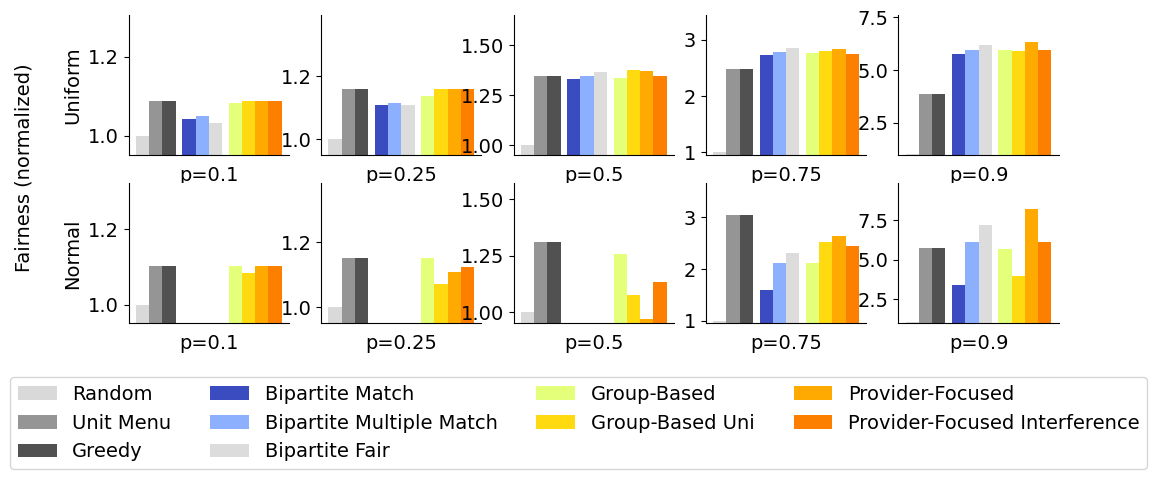

In [42]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_fairness','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite Fair",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_minimums'.format(m)][0])
                std_by_n.append(results['{}_minimums'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m])
                max_val = max(max_val,results['{}_minimums'.format(m)][0])

        axs[i,j].set_xticks([])

        axs[i,j].tick_params(axis='both', which='major', labelsize=14)

        axs[i,j].set_ylim([0.95,max_val*1.2])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.supylabel("Fairness (normalized)",fontsize=14,x=0.03)
fig.savefig("../../results/figures/fairness.pdf",dpi=300, bbox_inches='tight')


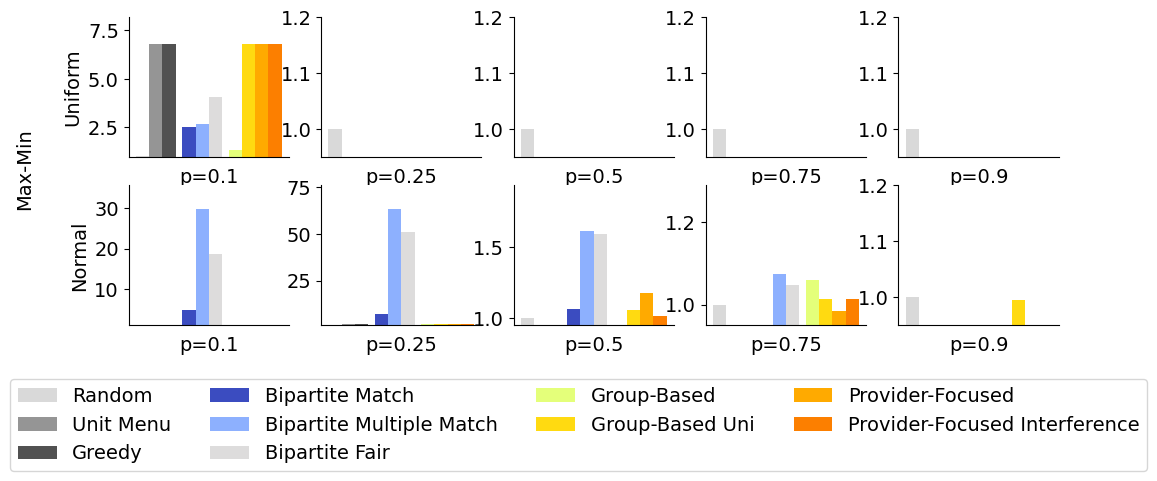

In [40]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_fairness','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite Fair",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_gaps'.format(m)][0])
                std_by_n.append(results['{}_gaps'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m])
                max_val = max(max_val,results['{}_gaps'.format(m)][0])

        axs[i,j].set_xticks([])

        axs[i,j].tick_params(axis='both', which='major', labelsize=14)

        axs[i,j].set_ylim([0.95,max_val*1.2])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.supylabel("Max-Min",fontsize=14,x=0.03)
fig.savefig("../../results/figures/fairness_gaps.pdf",dpi=300, bbox_inches='tight')


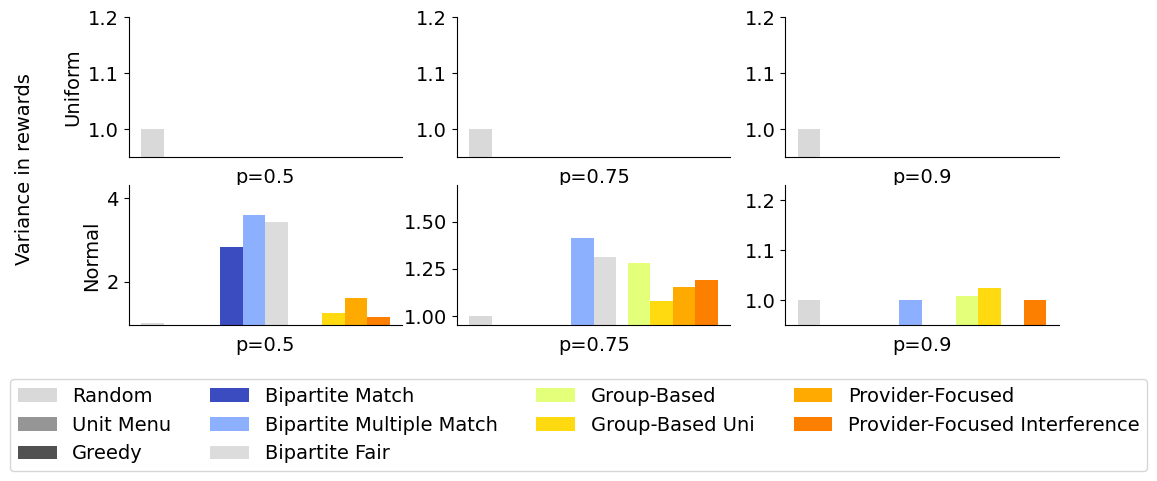

In [41]:
fig, axs = plt.subplots(2,3, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_fairness','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite Fair",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
p_choices = [0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_variance'.format(m)][0])
                std_by_n.append(results['{}_variance'.format(m)][1]/(num_data**.5))
                                

                axs[i][j].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m])
                max_val = max(max_val,results['{}_variance'.format(m)][0])

        axs[i,j].set_xticks([])

        axs[i,j].tick_params(axis='both', which='major', labelsize=14)

        axs[i,j].set_ylim([0.95,max_val*1.2])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.supylabel("Variance in rewards",fontsize=14,x=0.03)
fig.savefig("../../results/figures/fairness_variance.pdf",dpi=300, bbox_inches='tight')


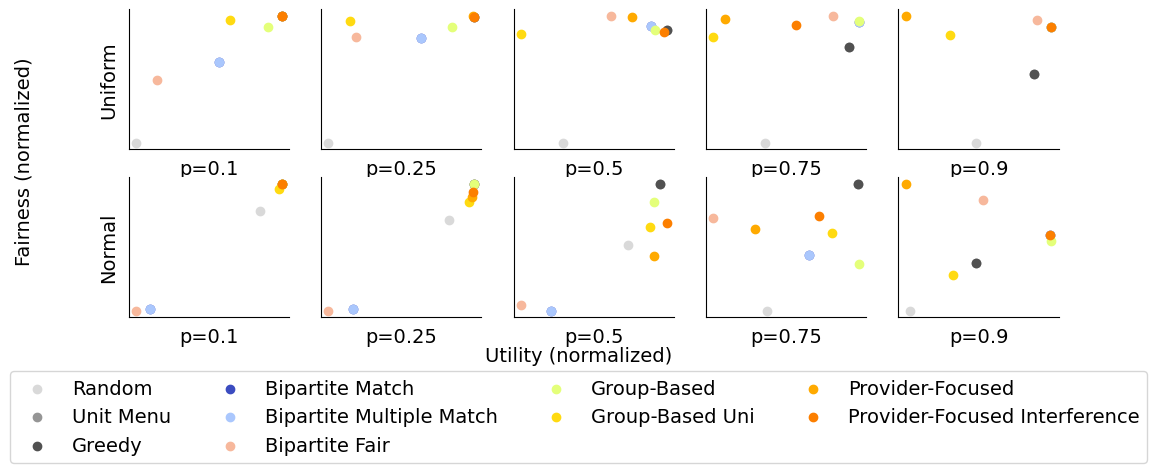

In [21]:
fig, axs = plt.subplots(2,5, figsize=(12, 4))
method_names = ['random','greedy_basic','greedy','lp','lp_multiple_match','lp_fairness','group_based','group_based_unidirectional','provider_focused','provider_focused_less_interference']
nice_names = ["Random","Unit Menu","Greedy","Bipartite Match","Bipartite Multiple Match","Bipartite Fair",'Group-Based','Group-Based Uni','Provider-Focused','Provider-Focused Interference']
width = 0.1
p_choices = [0.1,0.25,0.5,0.75,0.9]
utility_functions = ['uniform','normal']

baseline_params = {'provider_capacity': 1, 'choice_model': 'uniform_choice','exit_option': 0.5,'num_trials': 100, 'num_patients': 25, 'num_providers': 25, 'max_menu_size': 50}

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] in ['lp','group_based']:
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i,func in enumerate(utility_functions):
    for j,p in enumerate(p_choices):
        max_val = 0
        min_val = 1
        baseline_params['top_choice_prob'] = p
        baseline_params['utility_function'] = func
        temp_params = deepcopy(baseline_params)
        dataset = "policy_comparison"

        results = get_results_matching_parameters(dataset,"",temp_params)
        results = [i for i in results if i['parameters']['seed']]
        num_data = 0
        if len(results)>0:
            num_data = len(results)
            results = aggregate_normalize_data(results,baseline="random")

        for k,m in enumerate(method_names):
            score_by_n = []
            utility_by_n = []
            std_by_n = []
            if num_data>0:
                score_by_n.append(results['{}_minimums'.format(m)][0])
                utility_by_n.append(results['{}_utilities'.format(m)][0])         

                axs[i][j].scatter([utility_by_n[-1]],[score_by_n[-1]],label=nice_names[k],color=colors_by_method[m])
        axs[i,j].set_xlabel("p={}".format(p),fontsize=14)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

axs[0,0].set_ylabel("Uniform",fontsize=14)
axs[1,0].set_ylabel("Normal",fontsize=14)

handles, labels = axs[1,1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,0),fontsize=14)
fig.supylabel("Fairness (normalized)",fontsize=14,x=0.03)
fig.supxlabel("Utility (normalized)",fontsize=14,y=-0.01)
fig.savefig("../../results/figures/fairness_scatter.pdf",dpi=300, bbox_inches='tight')


### Rebuttal Plots

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_swaps_legacy','offline_solution_loose_constraints']
nice_names = ["Random","Greedy","Bipartite Match","Group-based", "Modified Bipartite Match"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_patients': 25, 'max_menu_size': 5}
dataset = "providers_patients"
num_providers = [5,10,25,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_providers'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    num_data = 0
    results = [i for i in results if 'offline_solution_swaps_legacy_utilities' in i]
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')
    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.8,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)
fig.suptitle("Varying # of Providers",fontsize=18)

fig.savefig("../../results/figures/varied_providers.pdf",dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_swaps_legacy','offline_solution_loose_constraints']
nice_names = ["Random","Greedy","Bipartite Match","Group-based", "Modified Bipartite Match"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25, 'max_menu_size': 5}
dataset = "providers_patients"
num_providers = [5,10,25,50]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(num_providers)):
    baseline_params['num_patients'] = num_providers[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    results = [i for i in results if 'offline_solution_swaps_legacy_utilities' in i]

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.8,max_val*1.2])
        axs[i].set_xlabel(num_providers[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)
fig.suptitle("Varying # of Patients",fontsize=18)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/varied_patients.pdf",dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(1,5, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_swaps_legacy']
nice_names = ["Random","Greedy","Bipartite Match","Group-based", "Modified Bipartite Match"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'true_top_choice_prob': 0.5, 'choice_model': 'uniform_choice'}
dataset = "misspecification"
misspecification = [-0.25,-0.1,0,0.1,0.25]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(misspecification)):
    baseline_params['top_choice_prob'] = 0.5+misspecification[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    results = [i for i in results if 'offline_solution_swaps_legacy_utilities' in i]

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.8,max_val*1.2])
        axs[i].set_xlabel(misspecification[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)
fig.suptitle("Performance by Misspecification Level",fontsize=18)

handles, labels = axs[0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/misspecification.pdf",dpi=300, bbox_inches='tight')


In [ ]:
fig, axs = plt.subplots(1,4, figsize=(12, 4))
method_names = ['random','greedy','offline_solution','offline_solution_swaps_legacy']
nice_names = ["Random","Greedy","Bipartite Match","Group-based"]
width = 0.1
plt.figure(figsize=(7,4))

baseline_params = {'utility_function': 'uniform', 'num_providers': 25, 'num_patients': 25, 'true_top_choice_prob': 0.5, 'choice_model': 'mnl'}
dataset = "misspecification"
exit_options = [0.1,0.25,0.5,0.75]

x_locations = [] 
shift = 0
for i in range(len(method_names)):
    if method_names[i] == 'offline_solution' or method_names[i] == 'more_patients_than_providers':
        shift += 0.5 
    x_locations.append((i+shift)*width)

for i in range(len(exit_options)):
    baseline_params['exit_option'] = exit_options[i]
    max_val = 0
    results = get_results_matching_parameters(dataset,"",baseline_params)
    results = [i for i in results if 'offline_solution_swaps_legacy_utilities' in i]

    num_data = 0
    if len(results)>0:
        num_data = len(results)*len(results[0]['random_utilities'])
    results = aggregate_normalize_data(results,baseline='random')

    for k,m in enumerate(method_names):
        score_by_n = []
        std_by_n = []

        if '{}_utilities'.format(m) not in results:
            results['{}_utilities'.format(m)] = [0,0]
        score_by_n.append(results['{}_utilities'.format(m)][0])
        std_by_n.append(results['{}_utilities'.format(m)][1]/num_data**.5)

        if m == 'optimal':
            axs[i].hlines(score_by_n[0],-0.1,x_locations[-1],colors='green',linestyles='dashed',label='Optimal',color=colors_by_method[m])
        else:
            axs[i].bar(x_locations[k],score_by_n,width=width,label=nice_names[k],color=colors_by_method[m],yerr=std_by_n)
            max_val = max(max_val,results['{}_utilities'.format(m)][0])

        axs[i].set_xticks([])
        axs[i].tick_params(axis='both', which='major', labelsize=14)
        axs[i].set_ylim([0.8,max_val*1.2])
        axs[i].set_xlabel(exit_options[i],fontsize=14)
        

axs[0].set_ylabel("Normalized Reward",fontsize=14)

handles, labels = axs[0].get_legend_handles_labels()
fig.suptitle("MNL Models with Exit Options",fontsize=18)

fig.legend(handles, labels, loc='upper center',ncol=4,bbox_to_anchor=(0.5,-0.05),fontsize=14)

fig.savefig("../../results/figures/mnl_exit_options.pdf",dpi=300, bbox_inches='tight')
